In [1]:
# prompt: google mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install category_encoders
!pip install eli5

import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
import folium


pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Ignore all future warnings
warnings.filterwarnings("ignore")

# Or ignore specific warnings by message
warnings.filterwarnings("ignore", message="divide by zero encountered in double_scalars")

# Or ignore specific warnings by category
warnings.filterwarnings("ignore", category=DeprecationWarning)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107717 sha256=fd96705217941cc17e280362b5b30daac9fa05aaae443a20961472eaa8f8746a
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [3]:
# 데이터 불러오기
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Hotel Analysis/숙박시설 일일 객실 가격(최고, 최저, 평균) 정보.csv")
df

,LDGS_NM,OTA_NM,CTPRVN_NM,GUGUN_NM,LDGS_ADDR,EXTRC_DE,LDGMNT_DE,WKDAY_NM,MIN_PRC,MAX_PRC,AVRG_PRC
0,켄싱턴리조트 경주,BOOKING,경상,경주시,경북 경주시 보문로 182-29,20230616,20230626,Monday,109000,229000,162333
1,켄싱턴리조트 경주,BOOKING,경상,경주시,경북 경주시 보문로 182-29,20230616,20230627,Tuesday,109000,229000,162750
2,켄싱턴리조트 경주,BOOKING,경상,경주시,경북 경주시 보문로 182-29,20230616,20230628,Wednesday,109000,229000,162333
3,켄싱턴리조트 경주,BOOKING,경상,경주시,경북 경주시 보문로 182-29,20230616,20230629,Thursday,109000,229000,162333
4,켄싱턴리조트 경주,BOOKING,경상,경주시,경북 경주시 보문로 182-29,20230616,20230630,Friday,129000,279000,191222
...,...,...,...,...,...,...,...,...,...,...,...
321700,강릉 라피네 호텔,GOODCHOICE,강원,강릉시,강원 강릉시 구정면 회산로 58-12,20230628,20230629,Thursday,60000,100000,80000
321701,강릉 라피네 호텔,GOODCHOICE,강원,강릉시,강원 강릉시 구정면 회산로 58-12,20230628,20230630,Friday,80000,120000,100000
321702,강릉 라피네 호텔,GOODCHOICE,강원,강릉시,강원 강릉시 구정면 회산로 58-12,20230629,20230629,Thursday,60000,100000,80000
321703,강릉 라피네 호텔,GOODCHOICE,강원,강릉시,강원 강릉시 구정면 회산로 58-12,20230629,20230630,Friday,80000,115000,95833


In [4]:
# 결측치 및 데이터 타입 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321705 entries, 0 to 321704
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   LDGS_NM    321705 non-null  object
 1   OTA_NM     321705 non-null  object
 2   CTPRVN_NM  321705 non-null  object
 3   GUGUN_NM   321705 non-null  object
 4   LDGS_ADDR  321705 non-null  object
 5   EXTRC_DE   321705 non-null  int64 
 6   LDGMNT_DE  321705 non-null  int64 
 7   WKDAY_NM   321705 non-null  object
 8   MIN_PRC    321705 non-null  int64 
 9   MAX_PRC    321705 non-null  int64 
 10  AVRG_PRC   321705 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 27.0+ MB


In [5]:
# 데이터 전처리
def data_preprocessing(df):
  # 컬럼 이름 정제
  df.columns = ["Hotel", "OTA", "Province", "City", "Address", "Extract_date", "Date", "Day", "Min_price", "Max_price", "Average_price"]

  # 날짜형 데이터 정제 및 추출
  df['Extract_date'] = pd.to_datetime(df['Extract_date'], format='%Y%m%d').dt.strftime('%Y-%m-%d')
  df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d').dt.strftime('%Y-%m-%d')

  # 예약 신청날짜와 숙박입소 날짜 간의 인터벌 시간을 Lead_time 컬럼으로 생성
  df['Lead_time'] = (pd.to_datetime(df['Date']) - pd.to_datetime(df['Extract_date'])).dt.days.astype(int)

  # 컬럼 순서 정리
  df = df[["Hotel", "OTA", "Province", "City", "Address", "Extract_date", "Date", "Day", "Lead_time", "Min_price", "Max_price", "Average_price"]]
  return df

hotel_df = data_preprocessing(df)
hotel_df

,Hotel,OTA,Province,City,Address,Extract_date,Date,Day,Lead_time,Min_price,Max_price,Average_price
0,켄싱턴리조트 경주,BOOKING,경상,경주시,경북 경주시 보문로 182-29,2023-06-16,2023-06-26,Monday,10,109000,229000,162333
1,켄싱턴리조트 경주,BOOKING,경상,경주시,경북 경주시 보문로 182-29,2023-06-16,2023-06-27,Tuesday,11,109000,229000,162750
2,켄싱턴리조트 경주,BOOKING,경상,경주시,경북 경주시 보문로 182-29,2023-06-16,2023-06-28,Wednesday,12,109000,229000,162333
3,켄싱턴리조트 경주,BOOKING,경상,경주시,경북 경주시 보문로 182-29,2023-06-16,2023-06-29,Thursday,13,109000,229000,162333
4,켄싱턴리조트 경주,BOOKING,경상,경주시,경북 경주시 보문로 182-29,2023-06-16,2023-06-30,Friday,14,129000,279000,191222
...,...,...,...,...,...,...,...,...,...,...,...,...
321700,강릉 라피네 호텔,GOODCHOICE,강원,강릉시,강원 강릉시 구정면 회산로 58-12,2023-06-28,2023-06-29,Thursday,1,60000,100000,80000
321701,강릉 라피네 호텔,GOODCHOICE,강원,강릉시,강원 강릉시 구정면 회산로 58-12,2023-06-28,2023-06-30,Friday,2,80000,120000,100000
321702,강릉 라피네 호텔,GOODCHOICE,강원,강릉시,강원 강릉시 구정면 회산로 58-12,2023-06-29,2023-06-29,Thursday,0,60000,100000,80000
321703,강릉 라피네 호텔,GOODCHOICE,강원,강릉시,강원 강릉시 구정면 회산로 58-12,2023-06-29,2023-06-30,Friday,1,80000,115000,95833


## **Geopy와 Folium을 활용한 지도 그리기**
> 주소가 있는 데이터이므로 우선 위도와 경도를 추출해서 호텔 위치를 확인해본다.

In [6]:
# 위도 경도 추가

cities = hotel_df.City.unique()
cities_mapping = {}
for i in cities:
  try:
    cities_mapping[i] = [Nominatim(user_agent='South Korea').geocode(i).latitude,
                         Nominatim(user_agent='South Korea').geocode(i).longitude]
  except:
    cities_mapping[i] = [np.nan, np.nan]

hotel_df["latitude"] = hotel_df["City"].map(lambda x: cities_mapping[x][0])
hotel_df["longitude"] = hotel_df["City"].map(lambda x: cities_mapping[x][1])

df = hotel_df[~hotel_df.isna()]
df

,Hotel,OTA,Province,City,Address,Extract_date,Date,Day,Lead_time,Min_price,Max_price,Average_price,latitude,longitude
0,켄싱턴리조트 경주,BOOKING,경상,경주시,경북 경주시 보문로 182-29,2023-06-16,2023-06-26,Monday,10,109000,229000,162333,35.86,129.22
1,켄싱턴리조트 경주,BOOKING,경상,경주시,경북 경주시 보문로 182-29,2023-06-16,2023-06-27,Tuesday,11,109000,229000,162750,35.86,129.22
2,켄싱턴리조트 경주,BOOKING,경상,경주시,경북 경주시 보문로 182-29,2023-06-16,2023-06-28,Wednesday,12,109000,229000,162333,35.86,129.22
3,켄싱턴리조트 경주,BOOKING,경상,경주시,경북 경주시 보문로 182-29,2023-06-16,2023-06-29,Thursday,13,109000,229000,162333,35.86,129.22
4,켄싱턴리조트 경주,BOOKING,경상,경주시,경북 경주시 보문로 182-29,2023-06-16,2023-06-30,Friday,14,129000,279000,191222,35.86,129.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321700,강릉 라피네 호텔,GOODCHOICE,강원,강릉시,강원 강릉시 구정면 회산로 58-12,2023-06-28,2023-06-29,Thursday,1,60000,100000,80000,37.75,128.88
321701,강릉 라피네 호텔,GOODCHOICE,강원,강릉시,강원 강릉시 구정면 회산로 58-12,2023-06-28,2023-06-30,Friday,2,80000,120000,100000,37.75,128.88
321702,강릉 라피네 호텔,GOODCHOICE,강원,강릉시,강원 강릉시 구정면 회산로 58-12,2023-06-29,2023-06-29,Thursday,0,60000,100000,80000,37.75,128.88
321703,강릉 라피네 호텔,GOODCHOICE,강원,강릉시,강원 강릉시 구정면 회산로 58-12,2023-06-29,2023-06-30,Friday,1,80000,115000,95833,37.75,128.88


In [7]:
# 위도와 경도를 활용해서 데이터 내 호텔 위치를 지도에 표시

map = folium.Map(location=[37.566345, 126.977893], zoom_start=6.35)

for index, row in df.sample(1000).iterrows():
  try:
    marker = folium.Marker(
        location=[row['latitude'], row['longitude']],
        pup=row['Hotel']
        )
    map.add_child(marker)
  except:
    pass

map

>

## **데이터 통계량 확인**

In [8]:
hotel_df.describe()

,Lead_time,Min_price,Max_price,Average_price,latitude,longitude
count,321705.00,321705.00,321705.00,321705.00,321705.00,321705.00
mean,15.58,161944.91,299249.03,213915.50,36.27,127.87
std,9.15,98241.37,169495.18,114730.31,1.58,0.89
min,-1.00,45003.00,50000.00,50000.00,33.26,126.51
25%,8.00,97797.00,182109.00,136944.00,35.16,127.05
50%,16.00,135667.00,253008.00,186340.00,36.36,127.89
75%,24.00,198000.00,360000.00,259571.00,37.56,128.59
max,31.00,1026754.00,1133000.00,1031945.00,38.21,129.36


In [9]:
# 요일별 판매 객실수 확인
hotel_df.Day.value_counts()

Thursday     55641
Friday       54576
Wednesday    45217
Tuesday      45076
Monday       43763
Sunday       41995
Saturday     35437
Name: Day, dtype: int64

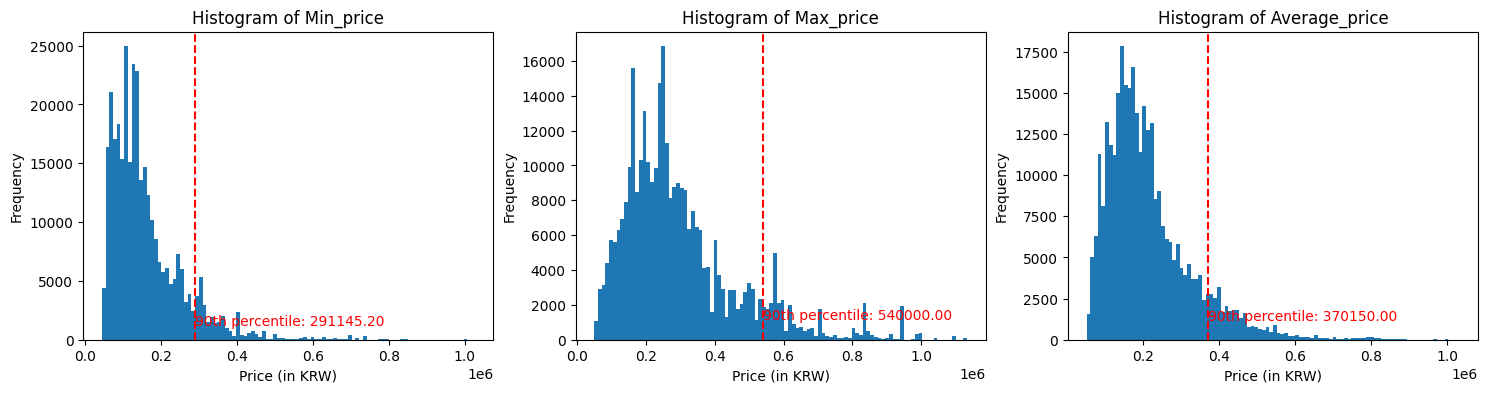

In [10]:
# 가격 컬럼에 대한 분포 시각화
columns_to_plot = ["Min_price", "Max_price", "Average_price"]

fig, axes = plt.subplots(1, len(columns_to_plot), figsize=(18, 4))
for i, column in enumerate(columns_to_plot):
  ax = axes[i]
  ax.hist(hotel_df[column], bins=100)
  ax.set_title(f"Histogram of {column}")
  ax.set_xlabel("Price (in KRW)")
  ax.set_ylabel("Frequency")

  # 분포의 90% 분기점을 지나는 선 생성
  percentile_90 = np.percentile(hotel_df[column], 90)

  ax.axvline(percentile_90, color="red", linestyle="--")
  ax.text(percentile_90, 1000, f"90th percentile: {percentile_90:.2f}", color="red",
          horizontalalignment='left', verticalalignment='bottom')

# 플롯 그리기
plt.show()

> * 2023.06.01 ~ 06.30 사이 한달간 수집된 데이터이며, 결측치나 다른 오기입 정보가 없는 없는 정제된 데이터이다.
> * 목요일, 금요일, 수요일 순으로 숙박하는 사람이 가장 많았고, 월, 일, 토 순서로 토요일이 예약이 가장 적었다.
> * 평균 호텔 객실가(ADR)은 4만 5천원 ~ 113만 3천원 사이로 다양하며, Budget 부터 Luxury 까지의 다양한 등급의 객실 데이터를 포함하고 있는 것으로 보인다.

## **다변량 통계치 분석 (Multi-variate Analysis)**

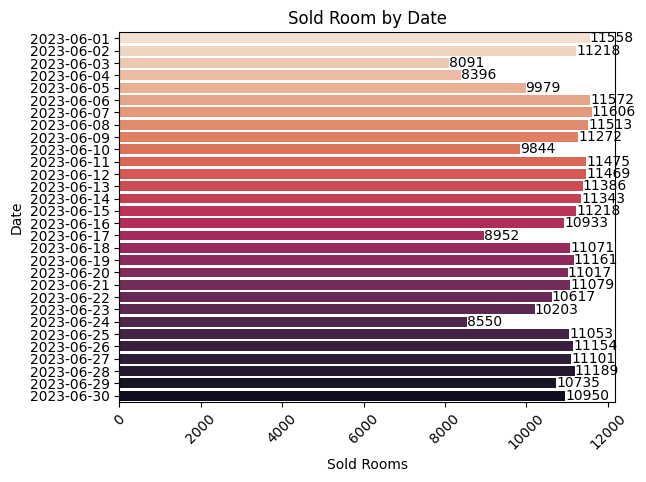

In [11]:
# 날짜별 판매 현황
ax = sns.countplot(y="Date", data=hotel_df, palette="rocket_r", order=sorted(hotel_df['Date'].value_counts().index))
plt.title("Sold Room by Date")
plt.ylabel("Date")
plt.xlabel("Sold Rooms")
plt.xticks(rotation=45)

# 수치 라벨링
for bar in ax.containers:
  ax.bar_label(bar, rotation=0)

# 플롯 그리기
plt.show()


> 주말에만 판매량이 떨어지고 있다.

In [12]:
# 지역별 가장 많이, 그리고 높은 금액으로 거래된 호텔

# 지역별 가장 많이 거래된 호텔
most_bookings_by_region = hotel_df.groupby('Province')['Hotel'].value_counts().sort_values(ascending=False).groupby(level=0).head(1)

# 지역별 가장 높은 금액으로 거래된 호텔
highest_price_by_region = hotel_df.groupby('Province')['Average_price'].mean().sort_values(ascending=False).groupby(level=0).head(1)

print("Most bookings by region:")
print(most_bookings_by_region)

print("\nHighest average price by region:")
print(highest_price_by_region)


#지역별 판매 객실 수를 비교
print("\n지역별 판매 객실 수:")
print(hotel_df['Province'].value_counts())


Most bookings by region:
Province  Hotel       
강원        라마다 속초 호텔       6608
경기        켄싱턴리조트 가평       6475
제주        더 그랜드 섬오름       6403
부산        힐튼부산            6318
서울        호텔 페이토 강남       6105
경상        대구 그랜드 호텔       5978
충청        에스앤나봄호텔         5398
전라        켄싱턴리조트 지리산남원    5366
Name: Hotel, dtype: int64

Highest average price by region:
Province
부산   360791.77
서울   251368.15
강원   217632.50
경기   210649.45
경상   199127.02
제주   192845.03
전라   168416.12
충청   138334.84
Name: Average_price, dtype: float64

지역별 판매 객실 수:
강원    89386
경상    52525
제주    45605
서울    43182
충청    33811
경기    24452
부산    20342
전라    12402
Name: Province, dtype: int64


In [13]:
# 서울에서 가장 많이 예약된 객실 호텔

most_bookings_seoul = hotel_df[hotel_df['Province'] == '서울'].groupby('Hotel')['Hotel'].count().sort_values(ascending=False)
print(f"서울에서 가장 많이 예약된 객실 호텔: {most_bookings_seoul}")


서울에서 가장 많이 예약된 객실 호텔: Hotel
호텔 페이토 강남               6105
스탠포드 호텔 명동              5644
호텔 스카이파크 명동 1호점         5449
호텔스카이파크 킹스타운 동대문        5433
보코서울강남                  5228
라까사 호텔 서울               5047
포포인츠 바이 쉐라톤 조선 서울 명동    4951
나비 호스텔 홍대               2094
강남아르누보씨티 호텔             1678
ac 호텔 바이 메리어트 서울 강남      708
신촌 코자 coza               631
오클라우드 호텔                 214
Name: Hotel, dtype: int64


In [14]:
# 서울에만 있는 호텔별 객실 row 개수 대비 Average_price를 비교

import pandas as pd

# Privince가 서울인 데이터만 필터링
seoul_hotels = hotel_df[hotel_df['Province'] == '서울']

# 호텔별 판매량 및 ADR Groupby 메소드로 집계
grouped_seoul_hotels = seoul_hotels.groupby('Hotel').agg(num_rows=('Hotel', 'count'), average_price=('Average_price', 'mean'))

# 내림차순으로 정렬
grouped_seoul_hotels = grouped_seoul_hotels.sort_values('num_rows', ascending=False)

# DataFrame의 형태로 출력
grouped_seoul_hotels


,num_rows,average_price
Hotel,,
호텔 페이토 강남,6105,155975.47
스탠포드 호텔 명동,5644,322213.82
호텔 스카이파크 명동 1호점,5449,173848.95
호텔스카이파크 킹스타운 동대문,5433,214470.22
보코서울강남,5228,408127.37
라까사 호텔 서울,5047,270328.94
포포인츠 바이 쉐라톤 조선 서울 명동,4951,280846.65
나비 호스텔 홍대,2094,122856.76
강남아르누보씨티 호텔,1678,246753.07


In [15]:
# 서울 객실 최다 판매 호텔 상위 5개에 대한 OTA 예약 현황

hotel_names = most_bookings_seoul.index.tolist()[:5]
top_5_hotel_ota_booking = hotel_df[hotel_df['Hotel'].isin(hotel_names)].groupby(['Hotel', 'OTA']).size().unstack().fillna(0).astype(int)
top_5_hotel_ota_booking['Total'] = top_5_hotel_ota_booking.sum(axis=1)
top_5_hotel_ota_booking = top_5_hotel_ota_booking.sort_values(by='Total', ascending=False)
top_5_hotel_ota_booking = top_5_hotel_ota_booking.T
top_5_hotel_ota_booking["OTA_Total"] = top_5_hotel_ota_booking.sum(axis=1)
top_5_hotel_ota_booking.sort_values(by='OTA_Total', ascending=False)[1:]


Hotel,호텔 페이토 강남,스탠포드 호텔 명동,호텔 스카이파크 명동 1호점,호텔스카이파크 킹스타운 동대문,보코서울강남,OTA_Total
OTA,,,,,,
AGODA,913,964,957,964,895,4693
EXPEDIA,886,967,929,907,889,4578
YANOLJA,898,959,926,915,863,4561
BOOKING,887,926,933,917,894,4557
GOODCHOICE,885,887,928,915,861,4476
HOTELS,767,819,776,760,731,3853
INTERPARK,869,122,0,0,95,1086
DAILY,0,0,0,55,0,55


In [16]:
# AGODA, EXPEDIA, YANOLJA, BOOKING, GOODCHOICE 가 가장 많이 판매한 호텔 상위 5개

ota_list = ['AGODA', 'EXPEDIA', 'YANOLJA', 'BOOKING', 'GOODCHOICE']
top_20_ota_hotel = {}
for ota in ota_list:
  top_20_ota_hotel[ota] = hotel_df[hotel_df['OTA'] == ota].groupby('Hotel')['Hotel'].count().sort_values(ascending=False).head(20)

for ota, top_20 in top_20_ota_hotel.items():
  print(f"\n{ota}가 가장 많이 판매한 호텔 상위 20개")
  print(top_20)



AGODA가 가장 많이 판매한 호텔 상위 20개
Hotel
스탠포드 호텔 명동               964
호텔스카이파크 킹스타운 동대문         964
평창 라마다호텔 스위트 바이 윈덤       963
대구 메리어트 호텔               962
속초 호텔 더 블루테라             959
라마다 속초 호텔                959
휘닉스평창 리조트                958
베니키아 테크노밸리 호텔            958
속초 씨크루즈호텔                957
호텔 스카이파크 명동 1호점          957
켄싱턴호텔 평창 구 켄싱턴 플로라 호텔    954
힐튼부산                     953
스터번 호텔                   953
오션힐 호텔 여수                949
켄싱턴리조트 가평                948
켄싱턴리조트 설악밸리              947
강릉 씨티호텔                  947
라마다 바이 윈덤 대전             947
소노벨 비발디파크 b c 구 오크 파인    946
w지우리조트                   945
Name: Hotel, dtype: int64

EXPEDIA가 가장 많이 판매한 호텔 상위 20개
Hotel
스탠포드 호텔 명동               967
대구 메리어트 호텔               963
속초 씨크루즈호텔                961
휘닉스평창 리조트                961
라마다 속초 호텔                960
베스트루이스해밀턴호텔 오션테라스        958
속초 호텔 더 블루테라             957
베니키아 테크노밸리 호텔            956
켄싱턴호텔 평창 구 켄싱턴 플로라 호텔    953
힐튼부산                     950
켄싱턴리조트 가평                943
호텔 스카

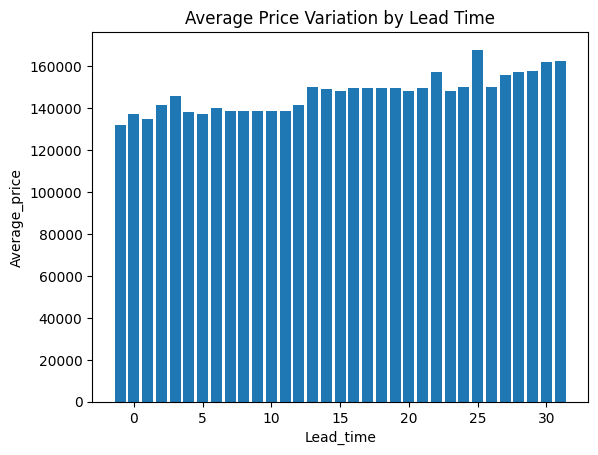

'호텔 페이토 강남'

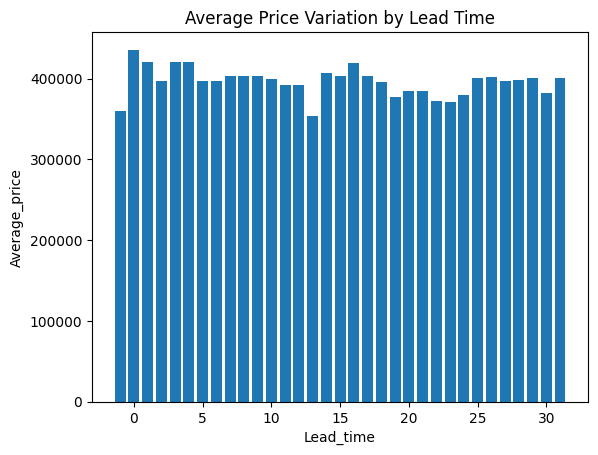

'스탠포드 호텔 명동'

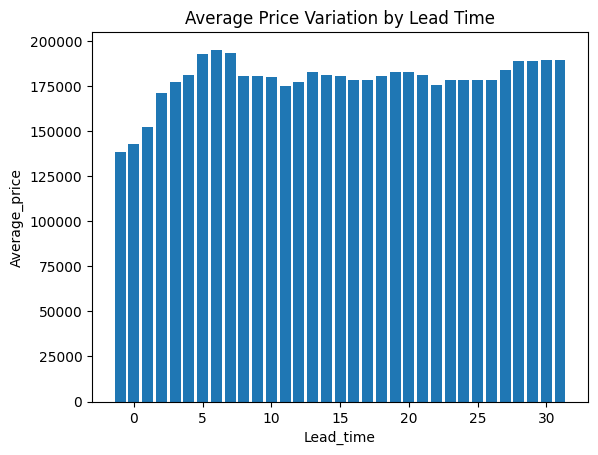

'호텔 스카이파크 명동 1호점'

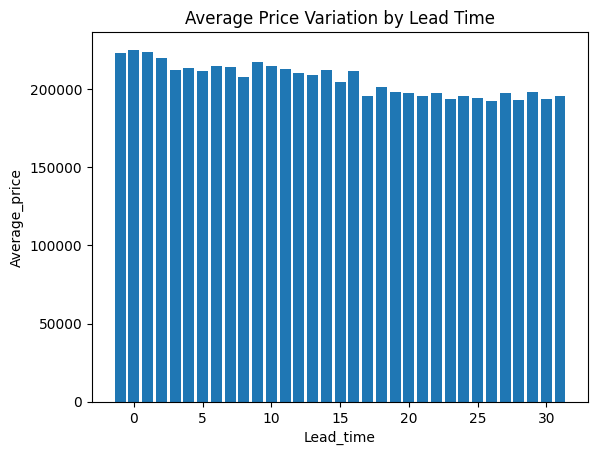

'호텔스카이파크 킹스타운 동대문'

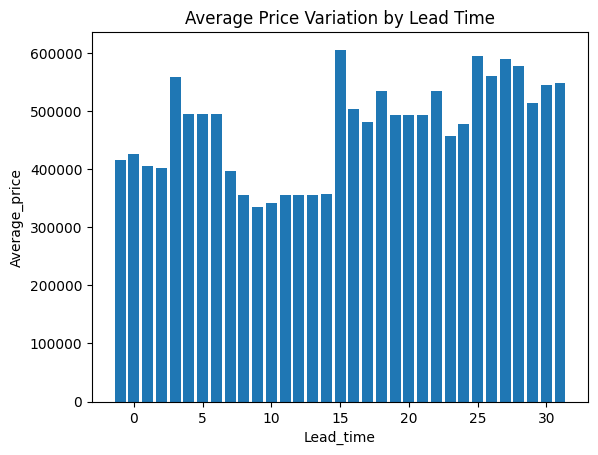

'보코서울강남'

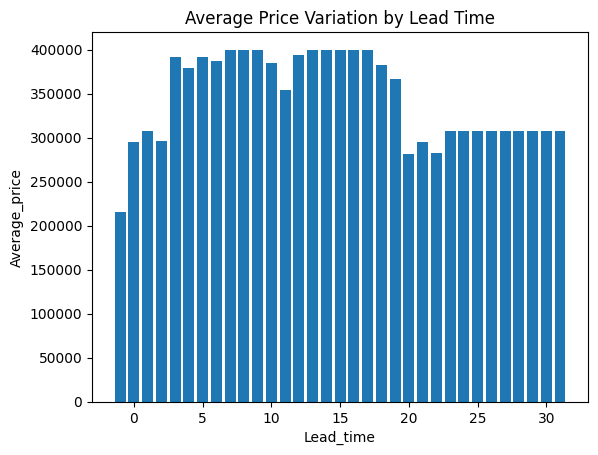

'라까사 호텔 서울'

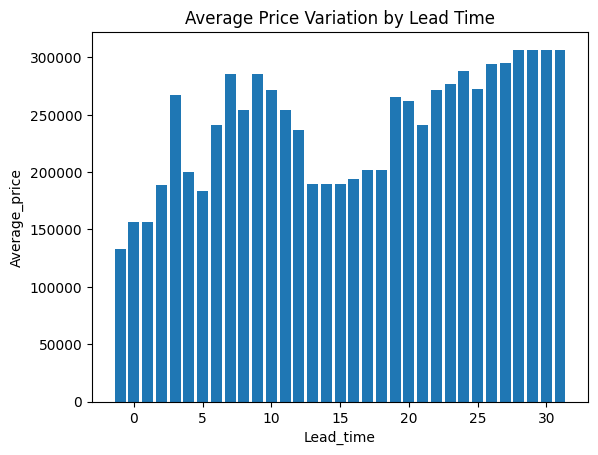

'포포인츠 바이 쉐라톤 조선 서울 명동'

In [17]:
# Lead_time(예약일부터 실제 체크인 일자까지의 기간) 에 따른 판매량 상위 5개 호텔별 판매 가격 분석

import matplotlib.pyplot as plt

def lead_time_comparison(df, hotel_name):
  # 가장 판매가 많았던 날 추출
  most_common_date = df[df['Hotel'] == hotel_name].groupby('Date').size().sort_values(ascending=False).index[0]
  # 특정 호텔의 특정 날짜인 데이터 행만 추출
  specific_hotel_and_date = df[(df['Hotel'] == hotel_name) & (df['Date'] == most_common_date)]

  # 바플롯으로 Lead_time에 따른 가격 변화 비교
  plt.bar(specific_hotel_and_date['Lead_time'], specific_hotel_and_date['Average_price'])
  plt.xlabel('Lead_time')
  plt.ylabel('Average_price')
  plt.title('Average Price Variation by Lead Time')
  plt.show()
  return hotel_name

for i in ["호텔 페이토 강남", "스탠포드 호텔 명동","호텔 스카이파크 명동 1호점","호텔스카이파크 킹스타운 동대문","보코서울강남","라까사 호텔 서울","포포인츠 바이 쉐라톤 조선 서울 명동"]:
  display(lead_time_comparison(hotel_df,i))


> Lead_time에 관해서는 호텔 별로 특징이 있지만, 일관된 패턴을 보이고 있지는 않다.

## **Machine Learning을 활용한 데이터 분석 진행**

In [18]:
df.columns

Index(['Hotel', 'OTA', 'Province', 'City', 'Address', 'Extract_date', 'Date',
       'Day', 'Lead_time', 'Min_price', 'Max_price', 'Average_price',
       'latitude', 'longitude'],
      dtype='object')

In [19]:
# 여러 트리 기반 비선형 인공지능 지도학습 모델을 비교하는 코드

from category_encoders import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# 데이터 준비
data = hotel_df.copy()
target = 'Average_price'
columns_to_drop = ['Province', 'Hotel', 'Address', 'Extract_date', 'Min_price', 'Max_price', 'latitude', 'longitude', 'Date', target]
features = data.drop(columns_to_drop, axis=1).columns.tolist()

# 범주형 변수 인코딩
categorical_features = ['OTA', 'City', 'Day']
encoder = OrdinalEncoder(cols=categorical_features)
data = encoder.fit_transform(data)
columns_list = data.columns.tolist()


# train, test, validation set 분리
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


# # 표준화 (트리 기반 비선형 모델에서는 필요하지 않음)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)

# 여러 비선형 모델 학습 및 평가
models = [
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    XGBRegressor()
]

for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print(f"{model.__class__.__name__}, RMSE: {rmse:.2f}")


DecisionTreeRegressor, RMSE: 81020.48
RandomForestRegressor, RMSE: 79710.21
GradientBoostingRegressor, RMSE: 77767.82
XGBRegressor, RMSE: 70672.05


XGBRegressor, RMSE: 70672.05


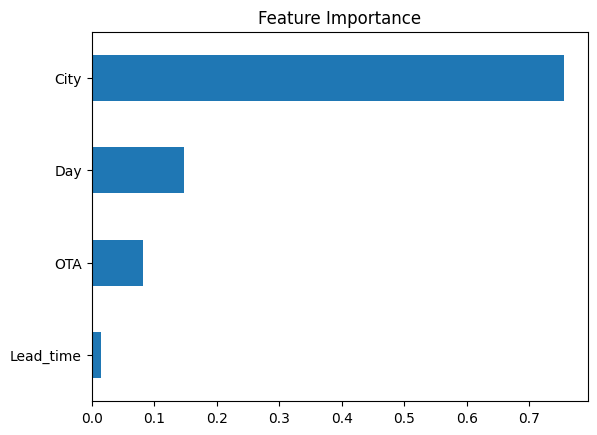

Text(0.5, 1.0, 'Cardinality')

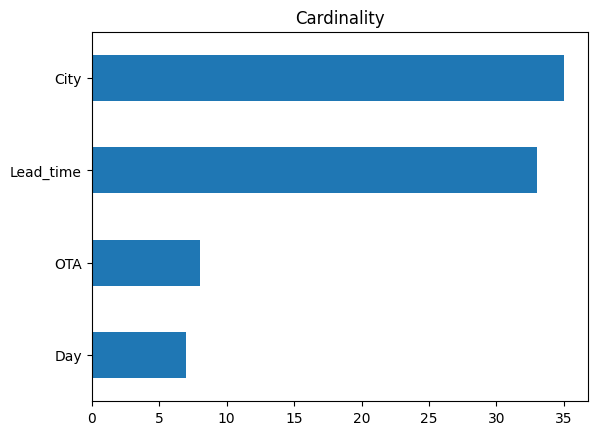

In [20]:
# XGBRegressor로 최종 모델 다시 학습
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"{xgb.__class__.__name__}, RMSE: {rmse:.2f}")


# 특성 중요도
importances = pd.Series(xgb.feature_importances_, X_train.columns)

importances.sort_values().plot.barh()
plt.title("Feature Importance")
plt.show()

X_train.nunique().sort_values().plot.barh()
plt.title("Cardinality")


Text(0.5, 1.0, 'Permutation Importance')

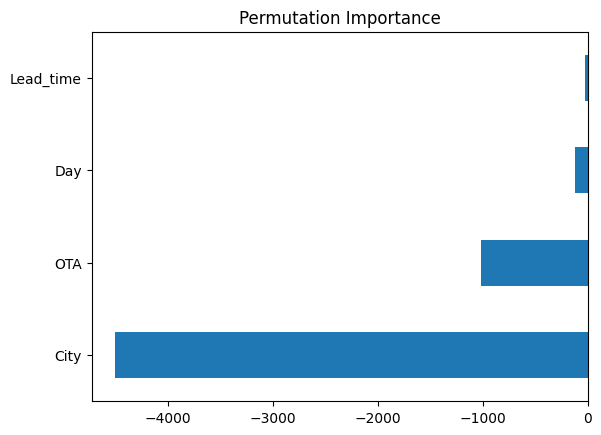

In [21]:
import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter = PermutationImportance(
    xgb,  # model
    scoring="neg_root_mean_squared_error",  # metric
    n_iter=10,  # 다른 random seed를 사용하여 10번 반복
    random_state=2,
)

# 스코어를 다시 계산
X_test_preprocessed = encoder.fit_transform(X_test)
permuter.fit(X_test_preprocessed, y_test)

feature_names = X_test.columns.tolist()
pi = pd.Series(permuter.feature_importances_, feature_names).sort_values()
pi.plot.barh()
plt.title("Permutation Importance")

> 특성 중요도와 순열 중요도를 보면, Lead_time 컬럼에 대해서 유의미한 결과가 있다고 보기는 어렵다.

# **데이터 분석 내용**
---------------------
## **Insights**
* 2023.06.01 ~ 06.30 사이 한달간 수집된 데이터이다.
* 평균 호텔 객실가(ADR)은 4만 5천원 ~ 113만 3천원 사이의 가격을 보이며, Budget 부터 Luxury 까지의 다양한 등급의 객실 데이터를 포함하고 있는 것으로 보인다.
* 목요일, 금요일, 수요일 순서로 숙박 예약하는 사람이 가장 많았고, 월, 일, 토 순으로 토요일 예약 및 객실 판매량이 가장 적었다.
* 분포를 확인해보면 데이터의 90% 이상이 평균 가격 기준으로 37만원 이하에 치우쳐 있다.
* 2023년 6월 한달간 강원, 경상, 제주 순으로 객실이 가장 많이 판매 되었는데, 2023년 6월은 엔데믹으로 인해 국내 여행수요가 해외로 빠지기 시작한 시점이기 때문에 이전에 예약이 이루어진 국내 여행에 대한 수요는 아직 유지되고 있다. 따라서 수도권이 아닌 외곽 지역에 대한 여행 수요를 보여주고 있다.
* 부산의 경우 판매량은 타 지역보다 적지만 서울 대비 높은 가격으로 판매되었다는 점에서 오션뷰와 같은 지리적인 이점이 있는 럭셔리 호텔 예약 비중이 많다는 사실을 알 수 있는데, 실제로 힐튼부산의 경우 평균 ADR이 535,000원임에도 불구하고 전국 4위로 가장 많이 예약한 호텔이다.
* 서울 객실 최다 판매 호텔 상위 10개를 보았을 때 강남, 명동, 홍대, 동대문 등 관광 중심지에 대한 예약이 많았다.
* OTA 예약 현황을 비교했을 때, AGODA, EXPEDIA, YANOLJA, BOOKING, GOODCHOICE 는 서로 유의미한 차이가 없는 예약 현황을 보였다.
  * 각각의 OTA에서 가장 많이 판매한 호텔 상위 20개를 추려 보았을 때, BOOKING.COM과 GOODCHOICE의 경우 수도권보다는 비수도권 및 지방 호텔 예약에서 가장 많은 판매가 이루어졌다.


## **한계점**
* 호텔 업계에서는  퍼포먼스를 측정하기 위해 Rev.Par(Occ. Rate * ADR)를 사용한다. 따라서, Occupancy를 측정할 수 있도록 객실 등급(Budget, Mid-Scale, UpScale, Deluxe, Luxury)과 호텔 별 총 객실 수에 대해서 세밀하게 분류할 수 있다면 더욱 정밀한 가격 측정이 가능하다고 생각한다.
* 또한, 고객군을 분리해서 해외 유입 고객, 국내 유입 고객, 연령 등의 다양한 정보를 제공받을 수 있다면 더욱 세밀한 마케팅 전략을 세워볼 수 있다.





------------------------------


# **Conclusion**

### **1. 가격 분포**
* 데이터의 90% 이상이 평균 가격 기준으로 37만원 이하에 치우쳐 있습니다.

* 이는 보다 경제적인 옵션을 선호하는 호텔 예약자들이 대부분이라는 것을 보여줍니다.

* 따라서, 지역 객실 평균 단가를 조사하고 손실 분기점을 넘지 않는 선에서 가격 경쟁력을 확보할 수 있다면, 더 많은 예약과 충성 고객을 확보하면서 호텔 최대 손실인 공실을 막을 수 있을 것으로 보입니다.

### **2. 요일별 예약 현황**
* 요일별 호텔 예약 현황을 보면 목요일, 금요일, 수요일 순서로 숙박 예약하는 사람이 가장 많았습니다.

* 해당 정보를 통해서 주말이 아닌 평일에 호텔을 이용하는 고객들이 많다는 것을 파악할 수 있었습니다.

* 이를 통해, 비즈니스 여행객 또는 주말을 피해 평일에 시간을 내서 여행하는 고객들을 타겟으로 한 상품 판매가 더욱 적극적으로 이루어져야 한다는 인사이트를 얻을 수 있었습니다.

### **3. 지역별 판매 현황**
* 지역별 판매 현황을 보면 강원, 경상, 제주 순으로 객실이 가장 많이 판매되었습니다.

* 특히, 수도권이 아닌 외곽 지역에 대한 여행 수요가 높은 것으로 보아 비즈니스 여행이 아닌 휴양객들의 수요가 더욱 높은 것으로 나타납니다.

> 국내 여행 수요가 해외로 빠지기 시작한 시점에도 불구하고 국내 여행 수요가 아직 유지되는 이유는 다음과 같이 생각해 볼 수 있습니다.
  1. 이전에 계획하고 이미 예약해 놓은 고객들의 국내 여행 수요가 관성적으로 지속되고 있기 때문입니다.
  2. 또한, 해외여행 수요가 높음에도 불구하고 항공권의 가격이 아직 높아서 국내 여행의 수요가 당분간은 지속될 것으로 예상됩니다.


### **4. 부산의 호텔 예약 현황**
* 부산의 경우 판매량은 타지역보다 적지만 수도권 대비 높은 가격으로 판매되었습니다.
* 특히, 오션뷰와 같은 지리적인 이점이 있는 지역에서는 럭셔리 호텔 예약 비중이 상대적으로 높았습니다.
* 럭셔리호텔에 대한 수요가 높은 만큼, 가격 경쟁력을 지니거나 제한된 고객 수요 대비 과도한 경쟁을 방지하기 위해 다른 지역을 물색해 볼 수도 있습니다.

### **5. OTA 예약 현황**
* OTA 예약 현황을 비교했을 때, AGODA, EXPEDIA, YANOLJA, BOOKING, GOODCHOICE 는 서로 유의미한 차이가 없는 예약 현황을 보였습니다.
* 다만, BOOKING.COM과 GOODCHOICE의 경우 판매 객실의 대부분이 수도권보다는 비수도권 호텔이었다는 점에서, 지방 호텔 판매에 대한 마케팅을 고려할 때 위와 같은 OTA에서 적극적으로 마케팅 활동을 수행해 볼 수 있습니다.

## **향후 방향성**
> 이러한 인사이트를 바탕으로 다음과 같은 향후 방향성을 제시할 수 있습니다.
1. 호텔 업계는 가격 경쟁력을 갖추는 것이 중요한 만큼, 주변 호텔에 대한 데이터 확보가 필요하다. 이를 위해 OTA 데이터를 활용한 분석을 통해 OTA별 특징을 파악하고 개별 전략을 수립해 볼 수 있다. (OTA 예약 현황의 지방 공략 OTA 등의 예시 활용 가능)
2. Occupancy를 측정할 수 있도록 객실 등급(Budget, Mid-Scale, UpScale, Deluxe, Luxury)과 호텔별 총 객실 수에 대해서 세밀하게 분류할 수 있다면 더욱 정밀한 ADR 예측이 가능하다.
3. 고객군을 분리해서 해외 유입 고객, 국내 유입 고객, 연령 등의 다양한 정보를 공유받을 수 있다면 더욱 세밀한 마케팅 전략을 세워볼 수 있다.
4. 평일에 호텔을 이용하는 고객들을 대상으로 한 마케팅 전략을 세우는 것이 고객 확보에 도움이 된다. 비즈니스뿐만 아니라 휴양객을 타겟으로 한 수도권 외 지역 공략이 필요하다. 특히, 부산과 같이 특정 지역적 이점을 가진 곳에서는 Luxury 호텔 시장을 고려해 볼 수 있다.



